# Práctica 1: Uso de embeddings preentrenados

Modifica el código anterior para adaptar el modelo LSTM al uso de embeddings preentrenados. Para ello, usa from torchtext.vocab import GloVe y elige el conjunto de embeddings GloVe que prefieras. Puedes encontrar más información en https://pytorch.org/text/stable/vocab.html#torchtext.vocab.GloVe

Verifica si se produce una mejora en la precisión del modelo.

In [1]:
!pip uninstall torch torchtext -y
!pip install torch==2.0.1 torchtext==0.15.2 --index-url https://download.pytorch.org/whl/cu118
!pip install portalocker>=2.0.0

Found existing installation: torch 2.0.1+cu118
Uninstalling torch-2.0.1+cu118:
  Successfully uninstalled torch-2.0.1+cu118
Found existing installation: torchtext 0.15.2+cpu
Uninstalling torchtext-0.15.2+cpu:
  Successfully uninstalled torchtext-0.15.2+cpu
Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.0.1%2Bcu118-cp310-cp310-linux_x86_64.whl (2267.3 MB)
  Using cached https://download.pytorch.org/whl/torchtext-0.15.2%2Bcpu-cp310-cp310-linux_x86_64.whl (2.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.4.1+cu121 requires torch==2.4.1, but you have torch 2.0.1+cu118 which is incompatible.
torchvision 0.19.1+cu121 requires torch==2.4.1, but you have torch 2.0.1+cu118 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import time

import torch.nn as nn
from torchtext import datasets
from torchtext.data import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe

from IPython.display import display, HTML

## 1. Cargar el dataset

El dataset "AG_NEWS" es un conjunto de datos ampliamente empleado en el ámbito del procesamiento del lenguaje natural (NLP) para tareas de clasificación de texto. Está compuesto por noticias de diversas categorías y se usa con frecuencia para clasificar textos. Este dataset incluye cuatro categorías principales de noticias:

1. **World**: Noticias sobre eventos globales, como política internacional, relaciones entre países y sucesos mundiales en general.
2. **Sports**: Información relacionada con deportes, como eventos, resultados de partidos y competiciones tanto nacionales como internacionales.
3. **Business**: Noticias del ámbito empresarial, financiero y económico, que abarcan temas como empresas, economía, informes de ganancias, entre otros.
4. **Sci/Tech**: Noticias vinculadas a la ciencia y tecnología, incluyendo avances científicos, innovaciones tecnológicas, gadgets y descubrimientos.

Cada registro en AG_NEWS típicamente incluye un título y el contenido de la noticia, junto con una etiqueta que indica la categoría correspondiente.

In [3]:
train_iter, test_iter = datasets.AG_NEWS(split=('train', 'test'))

train_ds = to_map_style_dataset(train_iter)
test_ds = to_map_style_dataset(test_iter)

train = np.array(train_ds)
test = np.array(test_ds)

## 2. Tokenización

Este código se utiliza para procesar texto en una tarea de procesamiento de lenguaje natural (NLP). Primero, se obtiene un *tokenizer* que convierte texto en una lista de palabras usando un enfoque básico de inglés. Luego, se construye un vocabulario a partir de un conjunto de datos de entrenamiento, donde cada texto es tokenizado, y se añaden dos tokens especiales: `'<pad>'` para el relleno y `'<unk>'` para palabras desconocidas. Se define el tamaño del vocabulario y se crea una función (*pipeline*) que convierte el texto en una secuencia de índices de palabras según el vocabulario, mientras que otra función convierte las etiquetas en enteros decreciendo en uno.

In [4]:
tokenizer = get_tokenizer("basic_english")

vocab = build_vocab_from_iterator(map(lambda x: tokenizer(x[1]), train_iter), specials=['<pad>','<unk>'])
vocab.set_default_index(vocab["<unk>"])

vocab_size = len(vocab)
print(f"Tamaño del vocabulario: {vocab_size}")

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

Tamaño del vocabulario: 95812


## 3. Dataloader

Se preparan los datos para ser utilizados el modelo. La función `collate_batch` toma un lote de muestras (batch), separa las etiquetas y los textos, y luego procesa los textos convirtiéndolos en tensores de números enteros mediante la función `text_pipeline`. Las etiquetas también se transforman con `label_pipeline`. Los textos se rellenan (padding) para que todos tengan la misma longitud, usando el token especial `'<pad>'`. Después, se crean dos *DataLoaders* para manejar el conjunto de datos de entrenamiento y prueba, con un tamaño de lote de 64, que usa `collate_batch` para procesar cada lote. Finalmente, se carga la matriz de embeddings preentrenados de GloVe para representar las palabras del vocabulario, asignando vectores de dimensión 100 a cada palabra en el vocabulario.

In [5]:
def collate_batch(batch):
    label_list, text_list = [], []
    for sample in batch:
        label, text = sample
        text_list.append(torch.tensor(text_pipeline(text), dtype=torch.long))
        label_list.append(label_pipeline(label))
    return torch.tensor(label_list, dtype=torch.long), torch.nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value=vocab["<pad>"])

train_dataloader = DataLoader(
    train_iter, batch_size=64, shuffle=True, collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_iter, batch_size=64, shuffle=True, collate_fn=collate_batch
)

En `torchtext.vocab.GloVe` se dispone de varios modelos preentrenados de *word embeddings* que permiten representar palabras en vectores numéricos. Algunos de los modelos disponibles son:

- **glove.42B.300d**: Entrenado en un corpus de 42 mil millones de palabras, con vectores de 300 dimensiones.
- **glove.840B.300d**: Entrenado en un corpus más extenso de 840 mil millones de palabras, con vectores de 300 dimensiones.
- **glove.twitter.27B.xxd**: Basado en 27 mil millones de palabras de Twitter, con vectores de 25,50,100 y 200 dimensiones.
- **glove.6B.50d**: Entrenado en un corpus de 6 mil millones de palabras, con vectores de 50, 100, 200 y 300 dimensiones.

Se han seleccionado los modelos **glove.6B** para este caso particular ya que, entre los diferentes disponibles, son los que tienen un menor tamaño en términos de almacenamiento y son más livianos en comparación con los entrenados en corpus más grandes, como los de 42B o 840B. Esto permite un balance adecuado entre rendimiento y consumo de recursos, ideal para tareas que no requieren un modelo de gran escala. A continuación, se cargan las matrices de embeddings para las distintas dimensiones del modelo **6B**:

- `glove_6B_50`: Modelo con 50 dimensiones, obteniendo la matriz de embeddings correspondiente (`embedding_matrix_50`).
- `glove_6B_100`: Modelo con 100 dimensiones, obteniendo la matriz (`embedding_matrix_100`).
- `glove_6B_200`: Modelo con 200 dimensiones, y su matriz de embeddings (`embedding_matrix_200`).
- `glove_6B_300`: Modelo con 300 dimensiones, con su correspondiente matriz (`embedding_matrix_300`).

Cada matriz se genera utilizando el vocabulario específico del modelo, asegurando que las representaciones de las palabras estén alineadas con los embeddings preentrenados.

In [6]:
glove_6B_50 = GloVe(name='6B', dim=50)
embedding_matrix_50 = glove_6B_50.get_vecs_by_tokens(vocab.get_itos())

glove_6B_100 = GloVe(name='6B', dim=100)
embedding_matrix_100 = glove_6B_100.get_vecs_by_tokens(vocab.get_itos())

glove_6B_200 = GloVe(name='6B', dim=200)
embedding_matrix_200 = glove_6B_200.get_vecs_by_tokens(vocab.get_itos())

glove_6B_300 = GloVe(name='6B', dim=300)
embedding_matrix_300 = glove_6B_300.get_vecs_by_tokens(vocab.get_itos())

## 4. Modelo LSTM

Este modelo, llamado `LSTMTextClassificationModel`, es una red neuronal para clasificación de texto que utiliza una arquitectura LSTM (*Long Short-Term Memory*), diseñada para capturar dependencias secuenciales en los datos de texto. Funciona de la siguiente manera:

1. **Inicialización**:
   - El modelo recibe el tamaño del vocabulario (`vocab_size`), la dimensión de los embeddings (`embed_dim`), la dimensión oculta del LSTM (`hidden_dim`), el número de clases a predecir (`num_class`), y una matriz de embeddings preentrenados (`embedding_matrix`).
   - Se inicializa una capa de *embedding* que convierte palabras en vectores utilizando los embeddings preentrenados.
   - Se añade una capa LSTM, que procesa la secuencia de vectores para aprender las dependencias temporales del texto.
   - Finalmente, hay una capa completamente conectada (*fully connected* o `fc`) que reduce la salida del LSTM a una predicción sobre las clases.

2. **Forward Pass**:
   - El texto de entrada es convertido en vectores a través de la capa de embeddings.
   - Estos vectores se pasan por la capa LSTM, que genera una secuencia de representaciones ocultas.
   - De las salidas de la LSTM, se selecciona la última (que representa la última palabra del texto) y se pasa a través de la capa completamente conectada para obtener la predicción final sobre las clases.

In [7]:
class LSTMTextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_class, embedding_matrix):
        super(LSTMTextClassificationModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_class)

    def forward(self, text):
        embedded = self.embedding(text)
        lstm_out, _ = self.lstm(embedded)
        last_output = lstm_out[:, -1, :]
        output = self.fc(last_output)
        return output

In [8]:
model_50 = LSTMTextClassificationModel(vocab_size, glove_6B_50.dim, 64, 4, embedding_matrix_50)
model_100 = LSTMTextClassificationModel(vocab_size, glove_6B_100.dim, 64, 4, embedding_matrix_100)
model_200 = LSTMTextClassificationModel(vocab_size, glove_6B_200.dim, 64, 4, embedding_matrix_200)
model_300 = LSTMTextClassificationModel(vocab_size, glove_6B_300.dim, 64, 4, embedding_matrix_300)

## 5. Entrenamiento

En este apartado se procede a entrenar los distintos modelos con la finalidad de observar si existen diferencias entre las dimensiones del vector de *embedding*.

In [9]:
def train(model, dataloader, criterion, optimizer):

    model.train()
    total_acc, total_count, max_acc = 0, 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| {:5d} batches '
                  '| accuracy {:8.3f}'.format(idx, total_acc / total_count))

            if max_acc < total_acc / total_count:
                max_acc = total_acc / total_count

            total_acc, total_count = 0, 0
            start_time = time.time()
    return max_acc


def evaluate(model, dataloader, criterion):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [10]:
EPOCHS = 10
LR = 5

criterion = torch.nn.CrossEntropyLoss()
optimizer_50 = torch.optim.SGD(model_50.parameters(), lr=LR)
scheduler_50 = torch.optim.lr_scheduler.StepLR(optimizer_50, 1.0, gamma=0.1)

optimizer_100 = torch.optim.SGD(model_100.parameters(), lr=LR)
scheduler_100 = torch.optim.lr_scheduler.StepLR(optimizer_100, 1.0, gamma=0.1)

optimizer_200 = torch.optim.SGD(model_200.parameters(), lr=LR)
scheduler_200 = torch.optim.lr_scheduler.StepLR(optimizer_200, 1.0, gamma=0.1)

optimizer_300 = torch.optim.SGD(model_300.parameters(), lr=LR)
scheduler_300 = torch.optim.lr_scheduler.StepLR(optimizer_300, 1.0, gamma=0.1)

models = {
    "model_50": (model_50, optimizer_50, scheduler_50),
    "model_100": (model_100, optimizer_100, scheduler_100),
    "model_200": (model_200, optimizer_200, scheduler_200),
    "model_300": (model_300, optimizer_300, scheduler_300)
}

In [11]:
models_accuracy = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Test Accuracy'])

for model_name, (model, optimizer, scheduler) in models.items():
    display(HTML(f"<h1>Training {model_name}</h1>"))
    for epoch in range(1, EPOCHS + 1):
        epoch_start_time = time.time()

        accu_train = train(model, train_dataloader, criterion, optimizer)
        accu_val = evaluate(model, test_dataloader, criterion)

        if accu_train > accu_val:
            scheduler.step()

        print("-" * 59)
        print(
            "| end of epoch {:3d} | time: {:5.2f}s | "
            "valid accuracy {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, accu_val
            )
        )
        print("-" * 59)

    models_accuracy.loc[len(models_accuracy)] = {'Model': model_name, 'Train Accuracy': accu_train, 'Test Accuracy': accu_val}
    print("\n")

|   500 batches | accuracy    0.255
|  1000 batches | accuracy    0.255
|  1500 batches | accuracy    0.257
-----------------------------------------------------------
| end of epoch   1 | time: 124.95s | valid accuracy    0.637 
-----------------------------------------------------------
|   500 batches | accuracy    0.696
|  1000 batches | accuracy    0.800
|  1500 batches | accuracy    0.866
-----------------------------------------------------------
| end of epoch   2 | time: 117.29s | valid accuracy    0.874 
-----------------------------------------------------------
|   500 batches | accuracy    0.870
|  1000 batches | accuracy    0.883
|  1500 batches | accuracy    0.902
-----------------------------------------------------------
| end of epoch   3 | time: 116.96s | valid accuracy    0.883 
-----------------------------------------------------------
|   500 batches | accuracy    0.888
|  1000 batches | accuracy    0.898
|  1500 batches | accuracy    0.916
----------------------

|   500 batches | accuracy    0.253
|  1000 batches | accuracy    0.253
|  1500 batches | accuracy    0.306
-----------------------------------------------------------
| end of epoch   1 | time: 162.15s | valid accuracy    0.693 
-----------------------------------------------------------
|   500 batches | accuracy    0.685
|  1000 batches | accuracy    0.692
|  1500 batches | accuracy    0.856
-----------------------------------------------------------
| end of epoch   2 | time: 148.75s | valid accuracy    0.871 
-----------------------------------------------------------
|   500 batches | accuracy    0.879
|  1000 batches | accuracy    0.887
|  1500 batches | accuracy    0.902
-----------------------------------------------------------
| end of epoch   3 | time: 149.47s | valid accuracy    0.895 
-----------------------------------------------------------
|   500 batches | accuracy    0.890
|  1000 batches | accuracy    0.900
|  1500 batches | accuracy    0.916
----------------------

|   500 batches | accuracy    0.256
|  1000 batches | accuracy    0.252
|  1500 batches | accuracy    0.263
-----------------------------------------------------------
| end of epoch   1 | time: 219.61s | valid accuracy    0.638 
-----------------------------------------------------------
|   500 batches | accuracy    0.719
|  1000 batches | accuracy    0.854
|  1500 batches | accuracy    0.899
-----------------------------------------------------------
| end of epoch   2 | time: 194.93s | valid accuracy    0.893 
-----------------------------------------------------------
|   500 batches | accuracy    0.892
|  1000 batches | accuracy    0.900
|  1500 batches | accuracy    0.918
-----------------------------------------------------------
| end of epoch   3 | time: 195.68s | valid accuracy    0.903 
-----------------------------------------------------------
|   500 batches | accuracy    0.897
|  1000 batches | accuracy    0.903
|  1500 batches | accuracy    0.924
----------------------

|   500 batches | accuracy    0.256
|  1000 batches | accuracy    0.257
|  1500 batches | accuracy    0.277
-----------------------------------------------------------
| end of epoch   1 | time: 268.33s | valid accuracy    0.688 
-----------------------------------------------------------
|   500 batches | accuracy    0.771
|  1000 batches | accuracy    0.868
|  1500 batches | accuracy    0.901
-----------------------------------------------------------
| end of epoch   2 | time: 245.76s | valid accuracy    0.897 
-----------------------------------------------------------
|   500 batches | accuracy    0.896
|  1000 batches | accuracy    0.902
|  1500 batches | accuracy    0.921
-----------------------------------------------------------
| end of epoch   3 | time: 254.89s | valid accuracy    0.907 
-----------------------------------------------------------
|   500 batches | accuracy    0.899
|  1000 batches | accuracy    0.907
|  1500 batches | accuracy    0.928
----------------------

## 6. Evaluando los resultados obtenidos

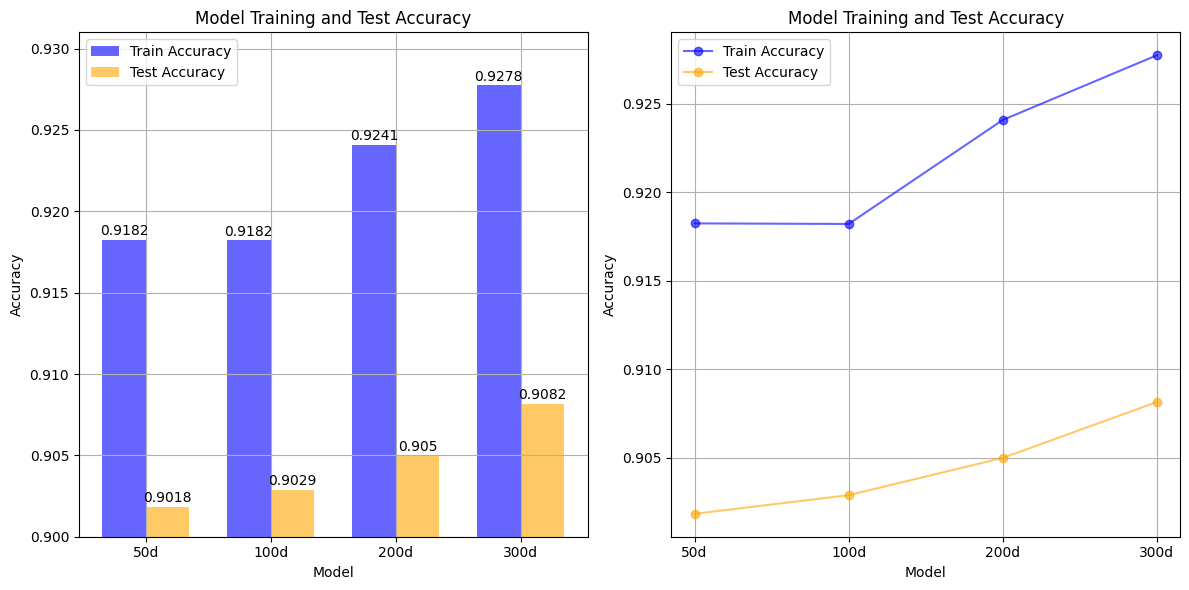

In [12]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
bar_width = 0.35
x = range(len(models_accuracy))

train_bars = plt.bar(x, models_accuracy['Train Accuracy'], width=bar_width, label='Train Accuracy', color='b', alpha=0.6)
test_bars = plt.bar([p + bar_width for p in x], models_accuracy['Test Accuracy'], width=bar_width, label='Test Accuracy', color='orange', alpha=0.6)

for bar in train_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.0001, round(yval, 4), ha='center', va='bottom')

for bar in test_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.0001, round(yval, 4), ha='center', va='bottom')

custom_labels = ['50d', '100d', '200d', '300d']
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Training and Test Accuracy')
plt.xticks([p + bar_width / 2 for p in x], custom_labels)
plt.legend()
plt.ylim(0.9, 0.931)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x, models_accuracy['Train Accuracy'], marker='o', label='Train Accuracy', color='b', alpha=0.6)
plt.plot(x, models_accuracy['Test Accuracy'], marker='o', label='Test Accuracy', color='orange', alpha=0.6)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Training and Test Accuracy')
plt.xticks(x, custom_labels)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

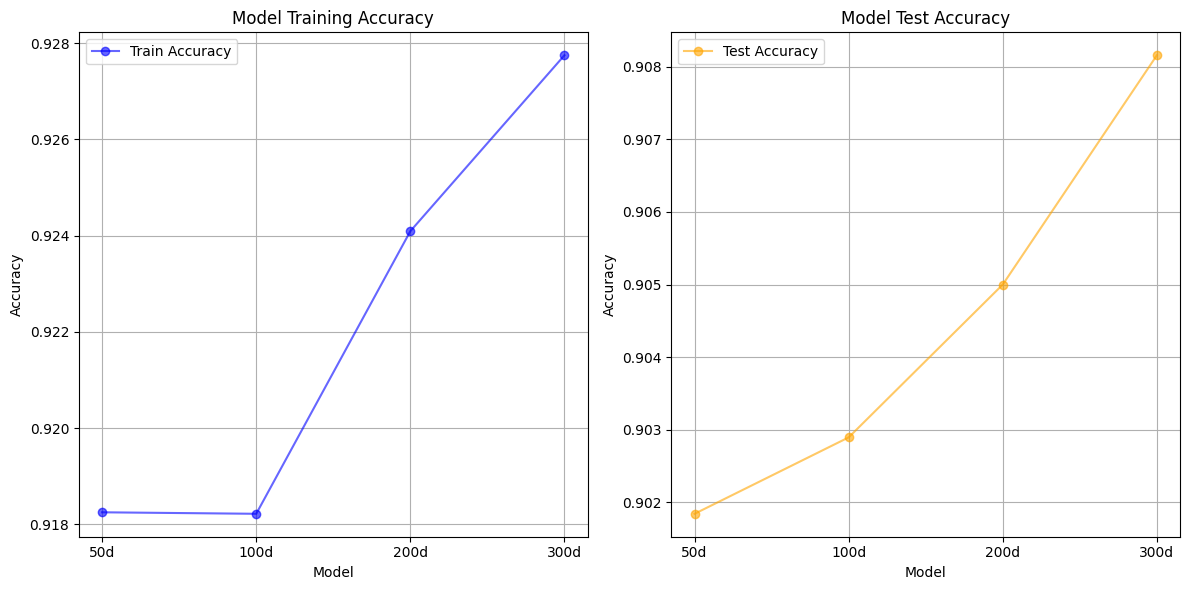

In [13]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
x = range(len(models_accuracy))
plt.plot(x, models_accuracy['Train Accuracy'], marker='o', label='Train Accuracy', color='b', alpha=0.6)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Training Accuracy')
plt.xticks(x, custom_labels)
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, models_accuracy['Test Accuracy'], marker='o', label='Test Accuracy', color='orange', alpha=0.6)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Test Accuracy')
plt.xticks(x, custom_labels)
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

Con base en los gráficos, se puede concluir que la precisión del modelo aumenta tanto en el conjunto de entrenamiento como en el de prueba a medida que se incrementa la complejidad del modelo. En el caso del **conjunto de entrenamiento**, la precisión se mantiene constante en los primeros modelos (50d y 100d) con un valor de 0.9182, pero aumenta gradualmente a medida que el modelo se hace más grande, alcanzando una precisión de 0.9278 en el modelo de 300d.

Por otro lado, la precisión en el **conjunto de prueba**, aunque es más baja que en el entrenamiento, también mejora conforme el modelo crece. Comienza en 0.9018 para el modelo de 50d, y aunque la mejora es menor, sigue una tendencia ascendente, alcanzando su punto máximo en 0.9082 con el modelo más grande (300d). Esta diferencia sugiere que el modelo está generalizando mejor con tamaños mayores, aunque la ganancia no es tan significativa.

Sin embargo, es importante notar que la diferencia entre la precisión del entrenamiento y la de prueba se amplía a medida que crece el tamaño del modelo, lo que podría indicar un **riesgo de sobreajuste** (overfitting). Esto sugiere que, aunque modelos más complejos logran mejores resultados, los incrementos en la precisión del conjunto de prueba son menores comparados con los del entrenamiento, lo que implica que seguir aumentando la complejidad podría llevar a rendimientos decrecientes.